# Cross-species translation of anatomical segmentation

[Previously, in WiMSE, we demonstrated an anatomically guided segmentation of the Uncinate Fasiculus in humans, using anatomical landmarks to define inclusion and exclusion criteria for streamlines](https://dannbullock.github.io/WiMSE/notebooks/Example_Segmentation-uncinate_fasiculus.html).  Because the cortical and subcortical structures of the human and monkey brain are evolutionarily related, there are homological mappings between these structures as well, such that structure __A<sub>Hu</sub>__ can be thought of as being the monkey equivalent of __A<sub>NHP</sub>__.  Furthermore, it stands to reason that the white matter structures of the brain are similarly homologous and preserved across these species.  Assuming (1) a preservation of the connective properties of the cortical and subcortical areas areas and (2) a preservation of the cortical and subcortical areas' relative positions, it should thus be possible to translate the criteria  used in the human segmentation into a potentially equally effective monkey segmentation.  Moreover, if we elect to use more positionally invariant / ancient structures (e.g. _NOT_ the neocortex) then we might reasonably expect either a higher probabiltiy of success and/or replicability with these criteria sets. 

To test this theory we can use this notebook to translate the segmentation criteriai and visualize their outcomes.

We'll begin by loading the relevant files and such.


In [1]:
#setting up paths to local files and resources
import subprocess
import os
#get top directory path of the current git repository, under the presumption that 
#the notebook was launched from within the repo directory
gitRepoPath=subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).decode('ascii').strip()

#establish path to the 
wma_toolsDirPath=os.path.join(gitRepoPath,'wma_pyTools')   

#change to the wma_tools path, load the function set, then change back to the top directory
os.chdir(wma_toolsDirPath)
import wmaPyTools.roiTools
import wmaPyTools.streamlineTools
import wmaPyTools.analysisTools
import wmaPyTools.visTools
import wmaPyTools.segmentationTools
os.chdir(gitRepoPath)

import nibabel as nib
import numpy as np
import pandas as pd
#establish a path to a CHARM + SARM parcellation, lookup table, and tractogram
charmParcPath='/media/dan/storage/data/exploreTractography/CHARM_SARM_5_LR_Split.nii.gz'
charmParc=nib.load(charmParcPath)
#I DONT KNOW WHY
charmParc=nib.nifti1.Nifti1Image(np.round(charmParc.get_data().astype(int)), charmParc.affine, charmParc.header)
charmParc.set_data_dtype(int)
                                 
charmSarmLUTPath='/media/dan/storage/data/exploreTractography/CHARM_SARM_key_5_LR_LUT.csv'
charmSarmLUT=pd.read_csv(charmSarmLUTPath)
testTractogramPath='/media/dan/storage/data/exploreTractography/test_1M_1.tck'
testTractogram=nib.streamlines.load(testTractogramPath)

/home/dan/.local/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/tmp/ipykernel_58655/3513078685.py:27: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  charmParc=nib.nifti1.Nifti1Image(np.round(charmParc.get_data().astype(int)), charmParc.affine, charmParc.header)


## Preprocessing the input parcellation and lookup tables

It's quite possible (and in this current case, guarenteed) that the input parcellation and lookup tables
will not be in the exactly right format for us to use.  As such we'll have to do a bit of preprocessing to fix these.  Also, we'll need to define some new functions for later use.

In [2]:
#load the respective hierarchy tables
pathToFullSARMkeyTable='/media/dan/storage/gitDir/homologyTranslation/SARM_key_table.csv'
FullSARMkeyTable=pd.read_csv(pathToFullSARMkeyTable)
pathToFullCHARMkeyTable='/media/dan/storage/gitDir/homologyTranslation/CHARM_key_table.csv'
FullCHARMkeyTable=pd.read_csv(pathToFullCHARMkeyTable)
#specify the offset used to delineate entries from SARM from CHARM
#Mark used +500, such that all default SARM labels have had 500 added to them.
#This seems to have worked pretty effectively.
sarmOffset=500
#also set the offset used to split LR ROIS
#Mark used +1000, such that all left labels have had 1000 added to them
#This seems to have worked pretty effectively.
lrOffset=1000

import re
#a +500 function
def addHalfKtoStrNum(inputString):
    identifiedNumMatch=re.search('[0-9]+', inputString)
    identifiedNum=identifiedNumMatch.group(0)
    newString=inputString.replace(identifiedNum,str(int(identifiedNum)+500))
    return newString
#a +1000 function
def addFullKtoStrNum(inputString):
    identifiedNumMatch=re.search('[0-9]+', inputString)
    identifiedNum=identifiedNumMatch.group(0)
    newString=inputString.replace(identifiedNum,str(int(identifiedNum)+1000))
    return newString

#apply the offset
sarmTableOffset=FullSARMkeyTable.applymap(lambda x:addHalfKtoStrNum(x) )
#merge them
charmSarmMerged=pd.concat([FullCHARMkeyTable,sarmTableOffset])
#create a left mapping of the rois
leftCharmSarm=charmSarmMerged.applymap(lambda x:addFullKtoStrNum(x))
#merge the initial charmSarm with the left charmSarm
charmSarmLR_LUT=pd.concat([charmSarmMerged,leftCharmSarm])

charmSarmStack=charmSarmLR_LUT.melt()
completeLUT=charmSarmStack['value'].str.split(': ',expand=True)
completeLUT[0]=completeLUT[0].apply(pd.to_numeric)
completeLUT=completeLUT.sort_values(by=[0])
completeLookupTable=completeLUT.rename(columns={0:'label',1:'name'})
#completeLookupTable['label']=completeLookupTable['label'].apply(pd.to_numeric)
reducedAtlas,reducedLUT=wmaPyTools.analysisTools.reduceAtlasAndLookupTable(charmParc,completeLookupTable,removeAbsentLabels=True,reduceRenameColumns=True)

#now we need to do a bunch of elaborate stuff in order to effectively move between
#levels in the hirearchy

#now that we have this we can borrow from Adriana's seaborn plotting project to help traverse the hirearchy
#except we'll be using the labels to identify 
def obtainHigherGrouping(hierarchyTable):
    """
    
    hierarchyTable = the pandas table of the anatomical hirearchy that is to be traversed, levels are 
    assumed to be columns, rows are presumed to be areas
    
    OUTPUTS
    hierarchyGroupings: an np array with the label identities extracted across all all levels
    
    """
    def extractNumber(inputString):
        identifiedNumMatch=re.search('[0-9]+', inputString)
        identifiedNum=identifiedNumMatch.group(0)
        return identifiedNum
    
    identityMappingArray=hierarchyTable.applymap(lambda x:int(extractNumber(x)) )
    
    return identityMappingArray.to_numpy()

def findSubLabels(charmLUT,targetValue):
    #yeah it works
    identityNumArray=obtainHigherGrouping(charmLUT)
    
    validLabels=[]
    for iIndexes,iRows in enumerate(identityNumArray):
        if np.any([iRows==targetValue for iVals in iRows]):
            currentLocation=np.where([iVals==targetValue for iVals in iRows])[0][0]
            #this could cause a problem
            
            validLabels.append(iRows[currentLocation:])
            
    uniqueVals=np.unique(validLabels)
    uniqueValsList=list(uniqueVals)
    uniqueValsList.remove(targetValue)
    return uniqueValsList

def convertToCurrentIndexes(charmSARM_LUT, reducedLUT, targetLabelIndex):
    """
    charmSARM_LUT:  The CHARM_SARM_key_table.csv input as a pandas dataframe.
    Will attempt to check the status of input to determine if the Mark-split has been applied
    
    reducedLUT:  A reduced version of the lookup table, based upon the labels found in the currently relevant
    brain parcellation nifti
    
    targetLabelIndex:  the index *from the post Mark-split* version of the parcellation.  This means that
    SARM ROI label numbers are +500 relative to default, and left ROIs are +1000 relative to default    
    
    """
    #do a check to see if it is not yet split
    #default charm SARM can't do this without inputting both charm and SARM
    #if len(charmLUT)<400 
    
    #find all of the candidate labels (i.e. those labels corresponding to the desired label OR
    #its sub components)
    targetIndexes=findSubLabels(charmSARM_LUT,targetLabelIndex)
    #generate a boolean vector mask for the reducedLUT labels (i.e. the ROI labels present
    #in the current parcellation) that is True if the label is either the target CHARM/SARM
    #index *or* one of its subcomponents.
    newIndexesBool=[iLabels in targetIndexes for iLabels in reducedLUT.iloc[:,0].values]
    #create a list of the indexes (which are continuously indexed, and correspond to the reduced index 
    #identities)
    newRequestedIndexes=reducedLUT.index[newIndexesBool].tolist()
    
    return newRequestedIndexes

def streamIndexesFromConnGroupDict(grouping,indexes1,indexes2,undirected=True):
    """
    

    Parameters
    ----------
    grouping : collections.defaultdict, dictionary
        The output grouping object dictionary from
        dipy.tracking.utils.connectivity_matrix
    indexes1 : list of int
        A list of integers corresponding to the labels that the desired
        streamlines are to be connected to.
    indexes2 : list of int
        A list of integers corresponding to the labels that the desired
        streamlines are to be connected to.
    undirected : Bool, optional
        Flag that indicates whether the requested lables are to be treated
        as undirected (i.e. indexes1 to indexes2 OR indexes2 to indexes1).
        The default is True.

    Returns
    -------
    streamIndexes : list of int
        A list of integers corresponding to the streamline indexes of the
        streamlines that meet the desired connectivity criteria.

    """
    #create a function that checks if the input indexes are in the specified cols in the key array
    def keyCheck(grouping,indexesIn1,indexesIn2):
        np.asarray(list(grouping.keys()))
        outBoolVec=np.zeros(len(grouping.keys()),dtype=bool)
        
        for iIndexes,iKeys in enumerate(list(grouping.keys())):
            criteria1=iKeys[0] in indexes1
            criteria2=iKeys[1] in indexes2
            outBoolVec[iIndexes]=np.all([criteria1,criteria2])
            
        return outBoolVec
    
    #if its undirected
    if undirected:
        #do it with both orderings
        outBoolVec1=keyCheck(grouping,indexes1,indexes2)
        outBoolVec2=keyCheck(grouping,indexes2,indexes1)
        #and combine the results
        keysToCheck=np.any([outBoolVec1,outBoolVec2],axis=0)
    else:
        outBoolVec1=keyCheck(grouping,indexes1,indexes2)
        #and combine the results
        keysToCheck=outBoolVec1
    
    #create a list to hold the streamline indexes
    streamsList=[]
    #now iterate across the keys and pull out the indexes
    for iIndexes,iBool in enumerate(keysToCheck):
        if iBool:
            streamsList.append(grouping[list(grouping.keys())[iIndexes]])
    
    #unpack the lists
    streamIndexes=[streamIndxs for sublist in streamsList for streamIndxs in sublist]
    
    return streamIndexes

#we'll use these later

## Example Segmentation: uncinate fasciculus

NOTE:  This segmentation is taken almost verbatim from a [recent version of the matlab-version of WMA segmentation](https://github.com/DanNBullock/wma_tools/blob/53a4d99b68b832257c55d5f1320dc7266cc8c270/Segmentations/bsc_segmentAntPostTracts_v4.m#L76-L207).

## Beginning with practical considerations and limitations

We'll begin by performing an initial full segmentation using dipy.  This is an expedited way to apply category criteria to the candidate streamlines

In [3]:
#inflate the atlas
#this does tend to take a while
#already done?
reducedAtlas=wmaPyTools.roiTools.inflateAtlasIntoWMandBG(reducedAtlas,2)

from dipy.tracking import utils
#segment tractome into connectivity matrix from parcellation
M, grouping=utils.connectivity_matrix(testTractogram.streamlines, reducedAtlas.affine, \
                        label_volume=reducedAtlas.get_data().astype(int), \
                        return_mapping=True,\
                        symmetric=False,\
                        mapping_as_streamlines=False)


208 of 260 voxels eroded label 1
0 of 260 voxels removed for label 1
77 of 90 voxels eroded label 2
0 of 90 voxels removed for label 2
233 of 263 voxels eroded label 3
2 of 263 voxels removed for label 3
546 of 547 voxels eroded label 4
6 of 547 voxels removed for label 4
179 of 188 voxels eroded label 5
4 of 188 voxels removed for label 5
264 of 317 voxels eroded label 6
4 of 317 voxels removed for label 6
805 of 822 voxels eroded label 7
2 of 822 voxels removed for label 7
159 of 172 voxels eroded label 8
0 of 172 voxels removed for label 8
444 of 445 voxels eroded label 9
0 of 445 voxels removed for label 9
1087 of 1140 voxels eroded label 10
0 of 1140 voxels removed for label 10
390 of 392 voxels eroded label 11
0 of 392 voxels removed for label 11
53 of 55 voxels eroded label 12
0 of 55 voxels removed for label 12
357 of 361 voxels eroded label 13
0 of 361 voxels removed for label 13
69 of 72 voxels eroded label 14
1 of 72 voxels removed for label 14
92 of 103 voxels eroded label 

39 of 41 voxels eroded label 121
2 of 41 voxels removed for label 121
228 of 263 voxels eroded label 122
0 of 263 voxels removed for label 122
251 of 254 voxels eroded label 123
7 of 254 voxels removed for label 123
44 of 46 voxels eroded label 124
1 of 46 voxels removed for label 124
0 of 1 voxels eroded label 125
0 of 1 voxels removed for label 125
0 of 28 voxels eroded label 126
0 of 28 voxels removed for label 126
0 of 28 voxels eroded label 127
0 of 28 voxels removed for label 127
0 of 11 voxels eroded label 128
0 of 11 voxels removed for label 128
0 of 5 voxels eroded label 129
0 of 5 voxels removed for label 129
0 of 17 voxels eroded label 130
0 of 17 voxels removed for label 130
0 of 10 voxels eroded label 131
0 of 10 voxels removed for label 131
195 of 196 voxels eroded label 132
4 of 196 voxels removed for label 132
53 of 58 voxels eroded label 133
0 of 58 voxels removed for label 133
0 of 47 voxels eroded label 134
0 of 47 voxels removed for label 134
0 of 3 voxels eroded la

0 of 15 voxels removed for label 239
0 of 41 voxels eroded label 240
0 of 41 voxels removed for label 240
0 of 16 voxels eroded label 241
0 of 16 voxels removed for label 241
72 of 80 voxels eroded label 242
0 of 80 voxels removed for label 242
0 of 1 voxels eroded label 243
0 of 1 voxels removed for label 243
201 of 269 voxels eroded label 244
0 of 269 voxels removed for label 244
70 of 83 voxels eroded label 245
0 of 83 voxels removed for label 245
216 of 230 voxels eroded label 246
1 of 230 voxels removed for label 246
713 of 729 voxels eroded label 247
0 of 729 voxels removed for label 247
189 of 198 voxels eroded label 248
1 of 198 voxels removed for label 248
295 of 356 voxels eroded label 249
1 of 356 voxels removed for label 249
833 of 860 voxels eroded label 250
0 of 860 voxels removed for label 250
152 of 166 voxels eroded label 251
0 of 166 voxels removed for label 251
337 of 430 voxels eroded label 252
3 of 430 voxels removed for label 252
935 of 972 voxels eroded label 253

1 of 103 voxels removed for label 353
657 of 660 voxels eroded label 354
0 of 660 voxels removed for label 354
245 of 257 voxels eroded label 355
1 of 257 voxels removed for label 355
0 of 55 voxels eroded label 356
0 of 55 voxels removed for label 356
663 of 686 voxels eroded label 357
0 of 686 voxels removed for label 357
164 of 200 voxels eroded label 358
0 of 200 voxels removed for label 358
59 of 64 voxels eroded label 359
1 of 64 voxels removed for label 359
97 of 109 voxels eroded label 360
2 of 109 voxels removed for label 360
108 of 115 voxels eroded label 361
5 of 115 voxels removed for label 361
0 of 26 voxels eroded label 362
0 of 26 voxels removed for label 362
226 of 254 voxels eroded label 363
0 of 254 voxels removed for label 363
226 of 230 voxels eroded label 364
4 of 230 voxels removed for label 364
40 of 45 voxels eroded label 365
0 of 45 voxels removed for label 365
0 of 2 voxels eroded label 366
0 of 2 voxels removed for label 366
0 of 28 voxels eroded label 367
0 

71 of 78 voxels eroded label 475
0 of 78 voxels removed for label 475
75 of 84 voxels eroded label 476
0 of 84 voxels removed for label 476
0 of 33 voxels eroded label 477
0 of 33 voxels removed for label 477
0 of 12 voxels eroded label 478
0 of 12 voxels removed for label 478
0 of 13 voxels eroded label 479
0 of 13 voxels removed for label 479
0 of 13 voxels eroded label 480
0 of 13 voxels removed for label 480
0 of 45 voxels eroded label 481
0 of 45 voxels removed for label 481
0 of 18 voxels eroded label 482
0 of 18 voxels removed for label 482
79 of 88 voxels eroded label 483
0 of 88 voxels removed for label 483
0 of 1 voxels eroded label 484
0 of 1 voxels removed for label 484
0 of 1 voxels eroded label 485
0 of 1 voxels removed for label 485
inflation iteration 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 69943/69943 [00:15<00:00, 4515.12it/s]


inflation iteration 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 36195/36195 [00:08<00:00, 4387.90it/s]
/tmp/ipykernel_58655/676143094.py:9: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  label_volume=reducedAtlas.get_data().astype(int), \


## Establishing the category

The Uncinate is definitionally a fronto-temporal tract.  Although we could be more specific than this, and note that it occupies the anterior temporal poles, we needn't actually be this specific for the purposes of applying a categorical segmentation.  Instead, we can simply use the existing fronto-temporal category.

Below, we'll visualize the relevant category.

/home/dan/.local/lib/python3.9/site-packages/fury/utils.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cols_arr = np.asarray(colors)


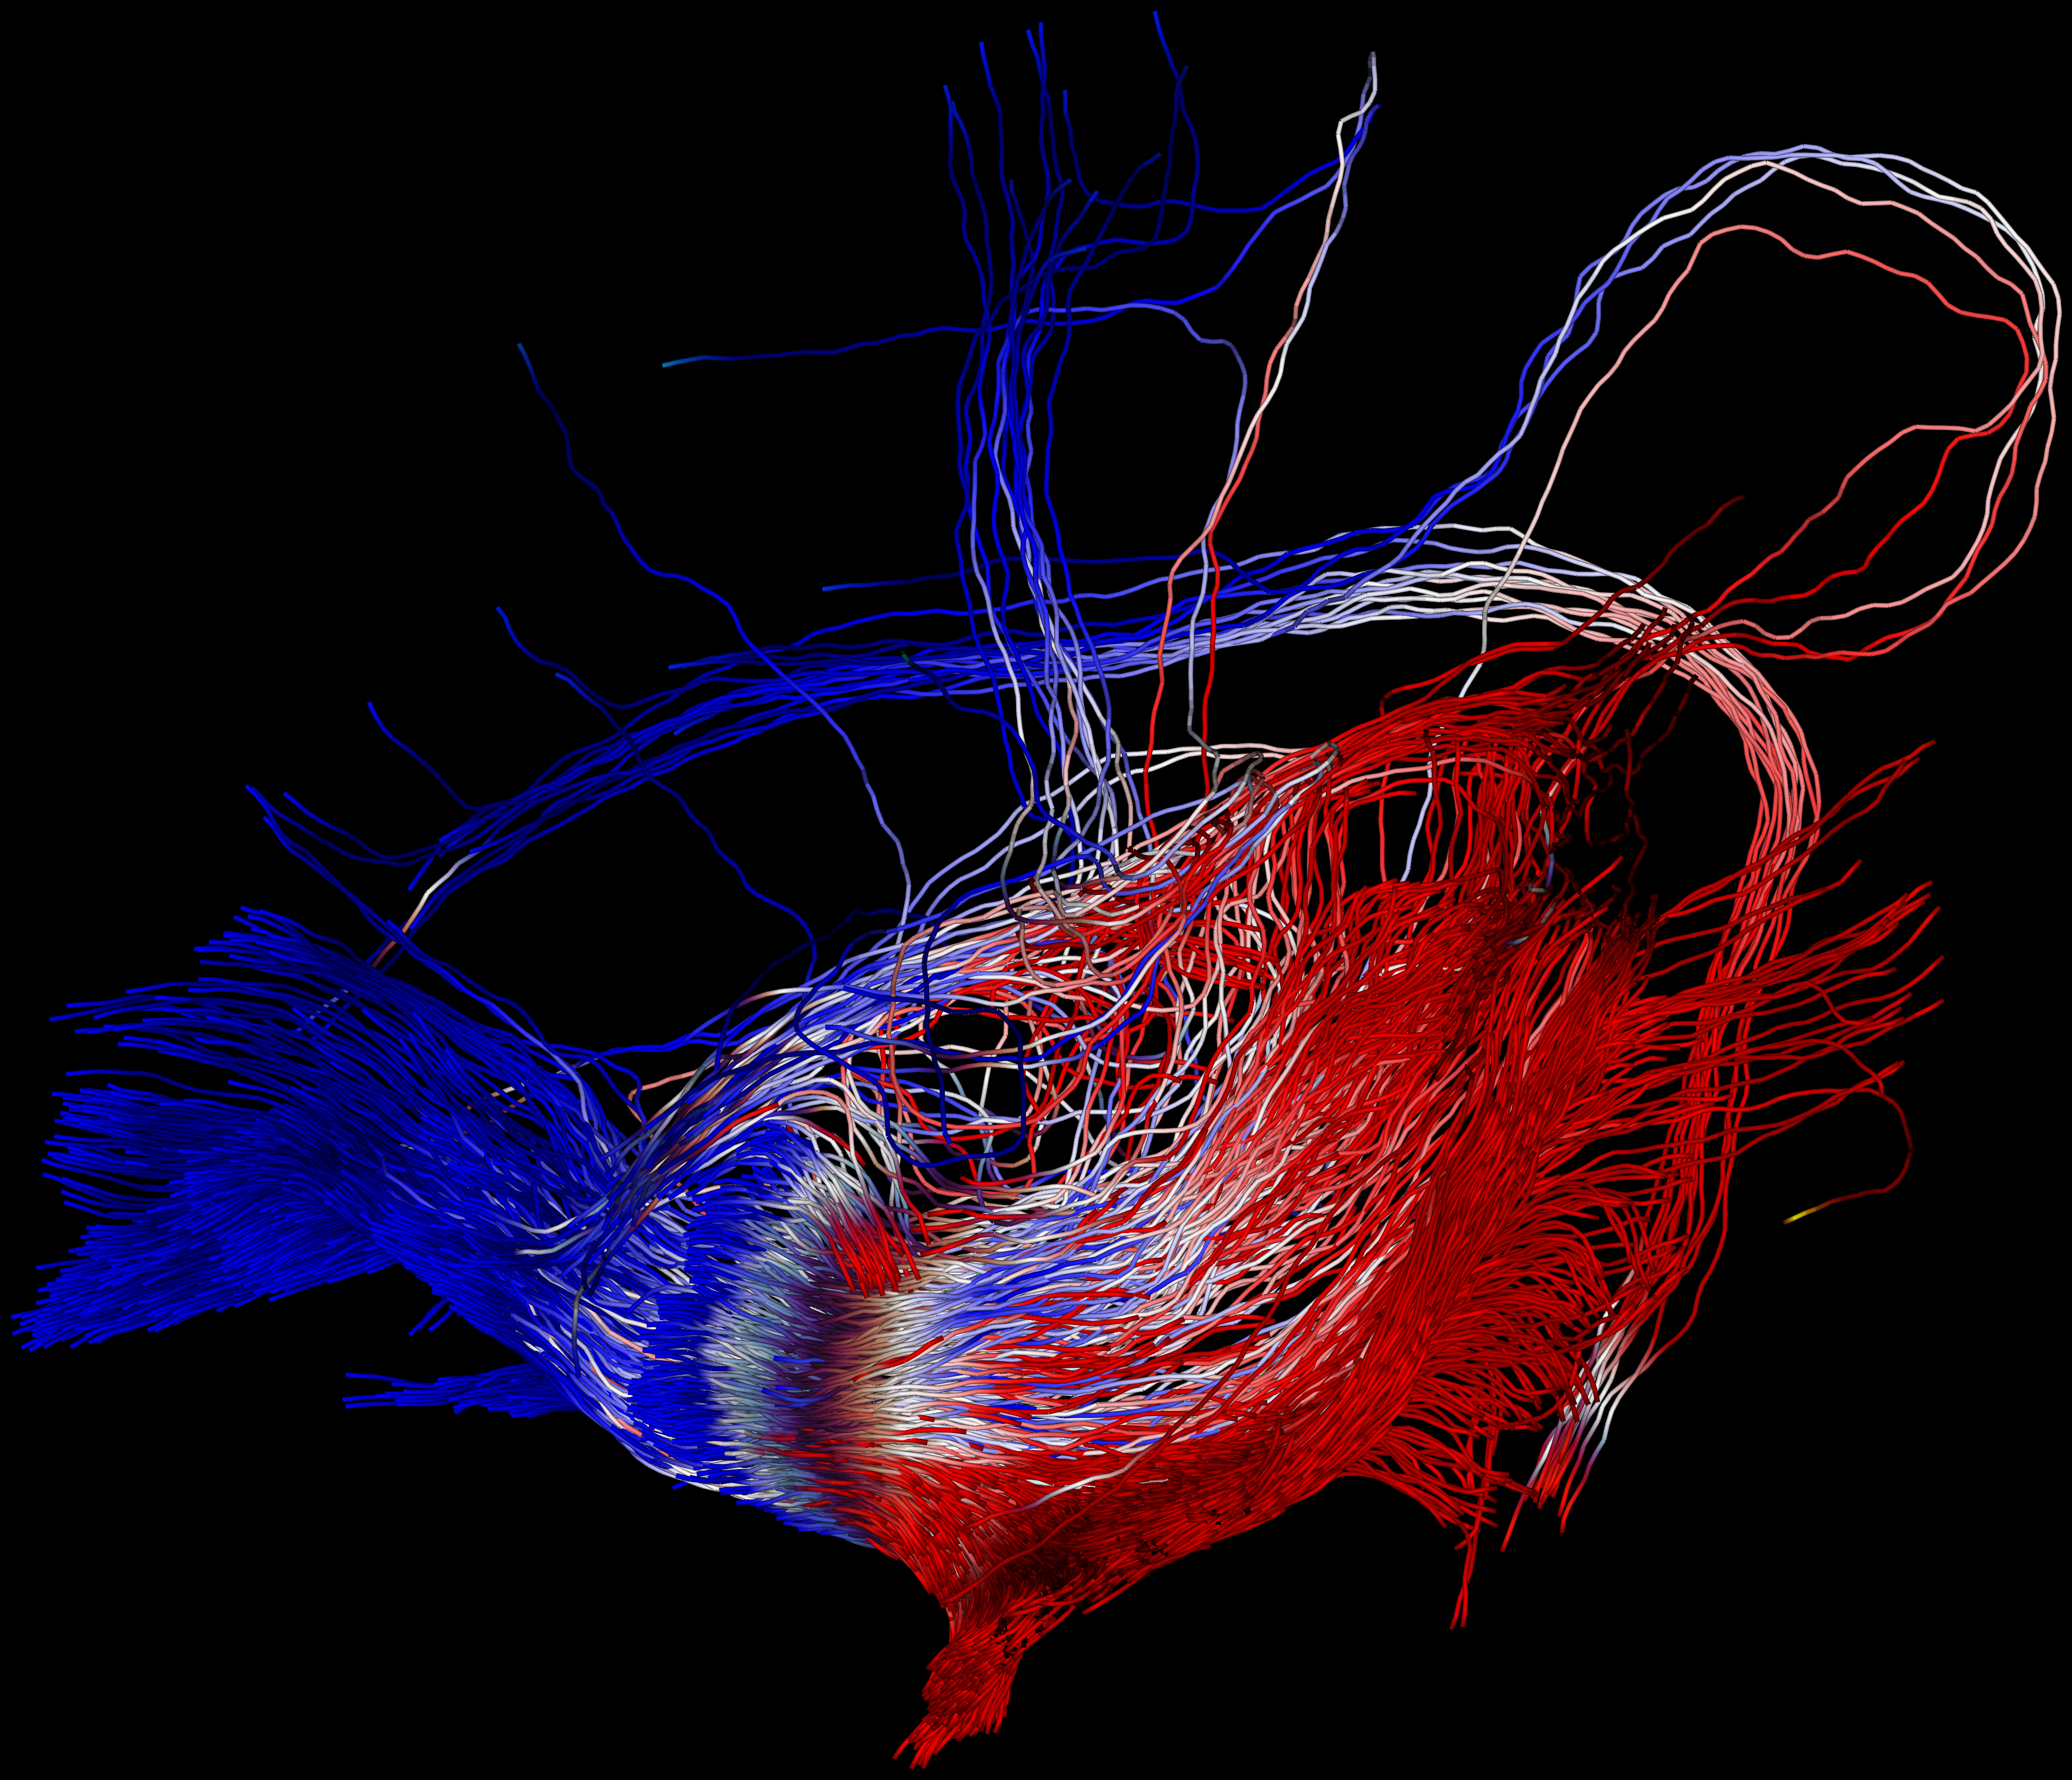

In [4]:
#1 is the index of the frontal lobe in CHARM, we'll stick with doing this on the right sdie for now
frontalIndexes=convertToCurrentIndexes(charmSarmLR_LUT, reducedLUT, 1001)
#138 is the index of the temporal lobe in CHARM,
temporalIndexes=convertToCurrentIndexes(charmSarmLR_LUT, reducedLUT, 1138)

frontoTemporalIndexes=streamIndexesFromConnGroupDict(grouping,frontalIndexes,temporalIndexes,undirected=True)
#create a boolean vector
categoryBool=np.zeros(len(testTractogram.streamlines),dtype=bool)
categoryBool[frontoTemporalIndexes]=True

wmaPyTools.visTools.dipyPlotTract(testTractogram.streamlines[frontoTemporalIndexes],refAnatT1=None, tractName='frontoTemporal',endpointColorDensityKernel=7)

from IPython.display import Image
Image(filename='frontoTemporal.png') 

In [5]:
reducedLUT

label                                               name
0       0                              unlabeled (unlabeled)
1       4                                  area_32 (area_32)
2       5                         subgenual_cortex (area_25)
3       7                     areas_24a_and_24b (area_24a/b)
4      10                                area_24c (area_24c)
..    ...                                                ...
481  1804  parvicellular_and_intermediate_reticular_nucle...
482  1805  dorsal_paragigantocellular_reticular_nucleus (...
483  1806             gigantocellular_reticular_nucleus (Gi)
484  1810                       Raphe_obscurus_nucleus (ROb)
485  1816                               pyramidal_tract (py)

[486 rows x 2 columns]

## Establish more specific endpoint criteria (loosely)
In order to prevent certain spurious streamlines (potentially implausible, and certainly not part of the Uncinate) we can include some additional segmentation logic to exclude these streamlines *while also not being so strict as to make the segmentation [brittle](https://en.wikipedia.org/wiki/Brittle_system) or [overdetermined](https://en.wikipedia.org/wiki/Overdetermined_system)*.  Two of these loose endpoint criteria will be necessary for the Uncinate.  Given that we require the posterior cluster of streamlines to be located in the anterior temporal region we can implement criteria relative to the dorso-ventral axis and the rostro-caudal axis. 
 
###  Dorso-ventral endpoint criteria

#### Dorso-ventral criteria - segmentation logic

In general, the endpoints of the Uncinate are fairly low in the brain.
Furthermore, we note that the arc of the Uncinate occurs relatively close to the amygdala.  Because the streamlines of the uncinate approach from the ventral side of the [amygdala](https://en.wikipedia.org/wiki/Amygdala) (as they then proceed anteriorly to the frontal lobes), and reach their apex at around the top of the amygdala, it is necessarily the case that at least one endpoint of these streamlines (namely the posterior/inferior endpoint) is _below_ the top of the amygdala.  Therefore, it is logically necessary that it is *not* the case that both streamline endpoints are superior to the top of the amygdala (or else it couldn't engage in the arcing behavior).  Lets translate this into segmentation logic.

First we will begin by generating a plane from the top of the amygdala.  Then we find all streamlines that have **both** streamline endpoints above this plane (we'll negate this criteria later, to adhere to our logic). Note, using the plane in this way is different than requiring neither streamline to be above this plane.  **This logical operation still permits maximally one endpoint per streamline to be above this plane** .

In [6]:
# Begin by generating a plane from the top of the amygdala
amygLabelNum=convertToCurrentIndexes(charmSarmLR_LUT, reducedLUT, 1516)
amygdalaTopPlane=wmaPyTools.roiTools.planarROIFromAtlasLabelBorder(reducedAtlas,amygLabelNum, 'superior')

# find all streamlines that have both streamline endpoints above this plane (we'll negate this criteria later, to generate our logic)
bothAboveAmygBool=wmaPyTools.segmentationTools.applyEndpointCriteria(testTractogram.streamlines,amygdalaTopPlane,'superior','both')

#compute the effect on the connectivity matrix
#bothAboveAmygLogicMatrix=wmaPyTools.segmentationTools.maskMatrixByBoolVec(grouping,np.logical_not(bothAboveAmygBool))
#sum across columns and make an array
#compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(bothAboveAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
#comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
#meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

#criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
#criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of endpoint dorso-ventral criteria')

####  Dorso-ventral criteria - observations

From the bar plot above, we see that the application of this criteria impacted some categories of streamlines more than others.  Note that, when computing the impact of this criteria we negated the output (using [np.logical_not](https://numpy.org/doc/stable/reference/generated/numpy.logical_not.html)) just as we will do when we actually utilize this output boolean vector to compute the final segmentation.  The parietal, and frontal, and occipital categories all exhibit a reduction in streamlines, whereas the temporal category appears to maintain most of its members (as would be expected for the more ventral structure).

### Rostro-caudal endpoint criteria

####  Rostro-caudal criteria - segmentation logic

In general, the endpoints of the Uncinate are fairly *anterior* in the brain as we noted above, the arc of the Uncinate occurs relatively close to the amygdala. This is true of the rostro-caudal axis as well. The streamlines of the Uncinate have all begun to arc forward anterior of the posterior of the border of the amygdala.  A consequence, similar to the one noted (in bold) in the dorso-ventral criteria discussion, is that it is *not* the case that both endpoints are posterior of this posterior amygdala border.  Lets translate this into segmentation logic.

We will begin by generating a plane from the posterior of the amygdala.  Next, we will use this to find all streamlines that have both streamline endpoints posterior to this plane (we'll negate this criteria later, to adhere to our logic). Note, this is different than requiring _neither_ streamline to be anterior to this plane.  **This logical operation still permits maximally one endpoint per streamline to be posterior to
this plane**.

In [7]:
# Begin by generating a plane from the top of the amygdala
amygLabelNum=convertToCurrentIndexes(charmSarmLR_LUT, reducedLUT, 1516)
amygdalaPosteriorPlane=wmaPyTools.roiTools.planarROIFromAtlasLabelBorder(reducedAtlas,amygLabelNum, 'posterior')

# find all streamlines that have both streamline endpoints above this plane (we'll negate this criteria later, to generate our logic)
bothPosteriorAmygBool=wmaPyTools.segmentationTools.applyEndpointCriteria(testTractogram.streamlines,amygdalaPosteriorPlane,'posterior','both')

#compute the effect on the connectivity matrix
#bothPostAmygLogicMatrix=wmaPyTools.segmentationTools.maskMatrixByBoolVec(grouping,np.logical_not(bothPosteriorAmygBool))
#sum across columns and make an array
#compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(bothPostAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
#comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
#meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

#criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
#criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of endpoint rostro-caudal criteria')

####  Rostro-caudal criteria - observations

As with the dorso-ventral criteria, we've negated the boolean vector once more, such that we are considering those streamlines which **do not** have both endpoints posterior to the amygdala.

The predominantly impacted categories in this instance are the occipital and cerebellar categories (and to a lesser extent, parietal).  This is consistent with our intent in using this criteria, because we are excluding streamlines confined to the posterior of the brain.

## Other anatomical criteria

### midpoint rostro-caudal criteria 

#### midpoint rostro-caudal criteria - segmentation logic

If the arc of the Uncinate occurs anterior to the posterior border of the amygdala, it stands to reason that the midpoint of those streamlines would also occur anterior to this border.  Even in the case of more [sigmoidally](https://en.wikipedia.org/wiki/Sigmoid_function) shaped streamlines (as opposed to u or j shaped), which do occur and have their endpoints potentially posterior to the posterior of the amygdala, the midpoint would still be anterior of this border if the anterior endpoint is to terminate in the anterior frontal lobes.  This can rather straightforwardly be translated into segmentation logic.

In [8]:
# Now we find all streamlines that the midpoint anterior of the same posterior amigdala plane we made earlier.
midpointAntOfPosteriorAmygBool=wmaPyTools.segmentationTools.applyMidpointCriteria(testTractogram.streamlines,amygdalaPosteriorPlane,'anterior');

#compute the effect on the connectivity matrix
#midpointAntAmygLogicMatrix=wmaPyTools.roiTools.maskMatrixByBoolVec(grouping,midpointAntOfPosteriorAmygBool)
#sum across columns and make an array
#compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(midpointAntAmygLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
#comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
#meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

#criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
#criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of midpoint rostro-caudal criteria')

#### midpoint rostro-caudal criteria - observations

Note that, in this case, we **did not** negate the outcome of the boolean vector.  This is because the output we obtained (midpoints anterior of the posterior amygdala) **is** what we want.  The primarily impacted categories are occipital and cerebellar (by a wide margin), but also parietal and temporal, to a lesser extent.

### posterior non-traversal criteria

#### posterior non-traversal criteria - segmentation logic

As it should have been clear by now the category segmentation is insufficient to isolate the Uncinate.  You can refer back to the category visualization from earlier in this chapter to confirm this for yourself.  Note that the majority of the non-Uncinate streamlines in the fronto-temporal category appear to be streamlines of the [Arcuate Fasciculus](https://en.wikipedia.org/wiki/Arcuate_fasciculus).  How can we exclude these streamlines?  By applying a plane that selectively targets the Arcuate streamlines.

Subcortical structures, like the [Thalamus](https://en.wikipedia.org/wiki/Thalamus) (and amygdala), tend to be relatively invariant in their location across subjects.  This is likely due to their proximity to the [anterior commissure](https://en.wikipedia.org/wiki/Anterior_commissure) (which serves as a central orientation point) and their comparative cross-subject [homology](https://en.wikipedia.org/wiki/Homology_(biology)) (as compared to the gyri and sulci of the cortex).  This is fortunate for us, because it looks like all of the Arcuate-like streamlines extend *past* the posterior of the thalamus.  Lets generate a planar ROI that we can use as an exclusion criterion.

In [9]:
thalLabelNum=convertToCurrentIndexes(charmSarmLR_LUT, reducedLUT, 1605)
posteriorThalPlane=wmaPyTools.roiTools.planarROIFromAtlasLabelBorder(reducedAtlas,thalLabelNum, 'posterior')


posteriorThalBool=wmaPyTools.segmentationTools.segmentTractMultiROI_fast(testTractogram.streamlines, [posteriorThalPlane], [True], ['any'])

#posteriorThalLogicMatrix=wmaPyTools.roiTools.maskMatrixByBoolVec(grouping,np.logical_not(posteriorThalBool))
#sum across columns and make an array
#compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(posteriorThalLogicMatrix,axis=1)))
#use pandas to create a dataframe for this
#comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
#meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

#criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
#criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of posterior non-traversal criteria')

volumes of input ROIs to check [8448.]
volumes of output ROIs to check [8448]
   roiVolumes  inclusionCriteria operations
0        8448               True        any
Computing streamline nodes within ROI bounding box


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:45<00:00, 21862.83it/s]


Subsetting streamlines
Appliying segmentation criterion


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 230332/230332 [00:25<00:00, 9034.79it/s]


#### posterior non-traversal criteria - observations

Interestingly, this criteria doesn't appear to have much of an effect.  Basically all we have done is excluded any streamline that crosses a specific plane (the posterior border of the thalamus), and as it turns out the overwhelming majority of streamlines don't do this.  In truth though, this criteria was targeting a very specific structure: the [Arcuate Fasciculus](https://en.wikipedia.org/wiki/Arcuate_fasciculus), which was partially visible in the fronto-temporal category at the start of this chapter.  Only a limited number of streamlines correspond to this, but it's nonetheless important that we exclude them, in order to get a good segmentation.

## Combine criteria and visualize

Below, we will selectively apply the criteria we have created and visualize the output.  You'll notice that this is a different widget than we have used previously.  To toggle a specific criteria from the list press control and click on the associated criteria name.  You can also shift click to select a range of criteria at once.  Also note that, because this is a widget within a widget, this visualization may take a moment to update when you change options.

The default criteria selection for this visualization results in the plotting of the right Uncinate Fasciculus.  You can switch between the left and right hemisphere criteria, but note that if both are activated then no streamlines will be plotted (by definition, there are no streamlines that are in both hemispheres that are also contained entirely within a single hemisphere).  It is interesting to observe just how close the pairing of the category criteria and the posterior traversal criteria get to segmenting this tract, however additional criteria are necessary to exclude those few fibers which remain dorsal to the Uncinate.

In [11]:
criteriaHolder=np.all([np.logical_not(bothAboveAmygBool),np.logical_not(bothPosteriorAmygBool),midpointAntOfPosteriorAmygBool,categoryBool],axis=0)
wmaPyTools.visTools.dipyPlotTract(testTractogram.streamlines[criteriaHolder],refAnatT1=None, tractName='maybeUncinate2',endpointColorDensityKernel=7)


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import SelectMultiple

criteriaList=['Dorso-ventral endpoint','Rostro-caudal endpoint','Rostro-caudal midpoint','Posterior non-traversal','Category','Right hemisphere','Left hemisphere']

def interpretCriteria(x):
    #might do some weird stuff for equal values
    import numpy as np
    return {
            'Dorso-ventral endpoint': np.logical_not(bothAboveAmygBool),
            'Rostro-caudal endpoint': np.logical_not(bothPosteriorAmygBool),
            'Rostro-caudal midpoint':  midpointAntOfPosteriorAmygBool,
            'Posterior non-traversal': np.logical_not(posteriorThalBool),
            'Category': categoryBool,
            'Right hemisphere': rightBool,
            'Left hemisphere': leftBool,
        }[x]

def updateSeg(commandIn):
    import numpy as np
    if len(commandIn)>0:
        criteriaOutArray=np.asarray(list(map(interpretCriteria,commandIn)))
        currentIndexes=np.concatenate(np.where(np.all(criteriaOutArray,axis=0)))
        
        subTractogram=extractSubTractogram(testTractogram,currentIndexes)
        %matplotlib inline
        if len(subTractogram.streamlines)>0:
            plotParcellationConnectionWidget(subTractogram.streamlines)
        else:
            print('no streamlines meet specified criteria')

#establish interactivity
interact(updateSeg, commandIn=SelectMultiple(options=criteriaList,value=criteriaList[0:-1], description='criteria',continuous_update=False,disabled=False))


## Quantitative assessment

In the plot below, you'll be able to select whatever combination of criteria you chose and view their impact on the overall count of streamlines in each category.  As was discussed in the chapter on categorical segmentations, you'll notice that the application of the category-specific criteria has the largest effect.  However, designing segmentations isn't just about quantity (of streamlines excluded) it's also about quality, which is why we need the other criteria as well.

In [ ]:
def barPlotCriteria(commandIn):
    import numpy as np
    import seaborn as sns
    if len(commandIn)>0:
        criteriaOutArray=np.asarray(list(map(interpretCriteria,commandIn)))
        
        combinedCriteriaMatrix=wmaPyTools.roiTools.maskMatrixByBoolVec(grouping,np.all(criteriaOutArray,axis=0))
        #sum across columns and make an array
        compareCriteriaArray=np.vstack((np.sum(M,axis=1),np.sum(combinedCriteriaMatrix,axis=1)))
        #use pandas to create a dataframe for this
        comparisonFrame=pd.DataFrame(data=compareCriteriaArray,columns=grossAnatList,index=['pre-criteria','post-criteria'])
        meltedFrame=pd.melt(comparisonFrame.reset_index(),id_vars='index')

        criteriaBarPlot=sns.barplot(data=meltedFrame,y='variable',x='value',hue='index')
        criteriaBarPlot.set(xlabel='streamline count (log)', ylabel='category',xscale='log',title='effect of selected criteria')
    else:
        print('no commands entered')
#establish interactivity
interact(barPlotCriteria, commandIn=SelectMultiple(options=criteriaList,description='criteria',disabled=False))

